# GridStatus <-> LBNL Status Mapping

GridStatus reads raw ISO queues. The LBNL queue statuses are standardized versions of ISO-specific categories. This notebook attempts to reverse engineer the mappings between the two.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

from dbcp.extract.lbnl_iso_queue import extract


/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

## Get the data
### LBNL-Compiled Queues

In [2]:
# partial implementation of transform. I don't want to include deduplication.
def partial_transform(active_projects: pd.DataFrame) -> pd.DataFrame:
    """Transform active iso queue data."""
    rename_dict = {
        "state": "raw_state_name",
        "county": "raw_county_name",
    }
    active_projects = active_projects.rename(columns=rename_dict)  # copy
    # Harmonize the interconnection_status_lbnl values.
    mapping = {
        "Feasability Study": "Feasibility Study",
        "Feasibility": "Feasibility Study",
        "Facilities Study": "Facility Study",
        "IA in Progress": "In Progress (unknown study)",
        "Unknown": "In Progress (unknown study)",
        "Withdrawn, Feasibility Study": "Withdrawn",
    }
    active_projects.loc[:, "interconnection_status_lbnl"] = active_projects.loc[
        :, "interconnection_status_lbnl"
    ].replace(mapping)
    # drop irrelevant columns (structurally all nan due to 'active' filter)
    active_projects.drop(columns=["date_withdrawn", "date_operational"], inplace=True)
    return active_projects


source_path = Path("/app/data/raw/queues_2022_clean_data.xlsx")
raw_lbnl = extract(source_path)["lbnl_iso_queue"]
lbnl = partial_transform(raw_lbnl)


In [3]:
lbnl.shape, lbnl.columns


((29033, 27),
 Index(['queue_id', 'queue_status', 'queue_date', 'queue_year', 'interconnection_date', 'entity', 'project_name', 'developer', 'utility', 'county_1', 'county_2', 'county_3', 'raw_state_name', 'region', 'interconnection_service_type', 'point_of_interconnection', 'date_proposed', 'year_proposed', 'interconnection_status_raw', 'interconnection_status_lbnl', 'resource_type_lbnl', 'resource_type_1', 'resource_type_2', 'resource_type_3', 'capacity_mw_resource_1', 'capacity_mw_resource_2', 'capacity_mw_resource_3'], dtype='object'))

In [4]:
lbnl.head(2)


,queue_id,queue_status,queue_date,queue_year,interconnection_date,entity,project_name,developer,utility,county_1,county_2,county_3,raw_state_name,region,interconnection_service_type,point_of_interconnection,date_proposed,year_proposed,interconnection_status_raw,interconnection_status_lbnl,resource_type_lbnl,resource_type_1,resource_type_2,resource_type_3,capacity_mw_resource_1,capacity_mw_resource_2,capacity_mw_resource_3
0,GIA-97,withdrawn,1/7/2022,2022.0,NaN,AEC,NaN,NaN,AEC,new madrid,NaN,NaN,MO,Southeast (non-ISO),Network,New Madrid - Essex 345kV,10/31/2024,2024.0,Withdrawn,Withdrawn,Solar,Solar,NaN,NaN,350.0,NaN,NaN
1,GIA-40,active,10/24/2009,2009.0,NaN,AEC,NaN,NaN,AEC,new madrid,NaN,NaN,MO,Southeast (non-ISO),Network Resource,NM Switchyard (345 kV Bus),11/1/2011,2011.0,Upgrade Approved,IA Executed,Coal,Coal,NaN,NaN,20.0,NaN,NaN


### GridStatus Queues

In [6]:
import dbcp

# These are the revision numbers of the oldest archives we have
iso_queue_versions: dict[str, str] = {
    "miso": "1681775160487863",
    "caiso": "1681775162586588",
    "pjm": "1681775160979859",
    "ercot": "1681775161342766",
    "spp": "1681775162935809",
    "nyiso": "1681775159356063",
    "isone": "1681775162111351",
}

gs_dfs = dbcp.extract.gridstatus_isoqueues.extract(iso_queue_versions)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-ka1m0ue4fptfmt9siejdd5lom7p39upa.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fpydata-google-auth.readthedocs.io%2Fen%2Flatest%2Foauth.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=NbZxDsuQq2WEEaFNnYzs36lVNpQ4jo&access_type=offline


Enter the authorization code:  4/0AfJohXlczLI81kalnAjTGF6X1MQPKEqoktpf3Z632D31A975thhqYIuRQ7g_4Cdo6AgP0w


In [7]:
{k: v.shape for k, v in gs_dfs.items()}

{'miso': (4253, 31),
 'caiso': (2278, 36),
 'pjm': (9030, 37),
 'ercot': (1203, 35),
 'spp': (950, 24),
 'nyiso': (1535, 24),
 'isone': (1533, 31)}

In [8]:
# # These are manually downloaded from our archives. I went back as far as I could,
# # which is April 17 2023.
# # There is a 3.5 month gap between the LBNL queues and our oldest GridStatus archive.
# root_path = Path("/app/data/raw/gridstatus/interconnection_queues")
# assert root_path.exists()
# # filenames are like "interconnection_queues_caiso_4-17-2023.parquet"
# gs_dfs = {
#     path.name.split("_")[2]: pd.read_parquet(path)
#     for path in root_path.glob("*.parquet")
# }
# {k: v.shape for k, v in gs_dfs.items()}


In [9]:
# wayyy fewer items in GridStatus than LBNL.
sum([v.shape[0] for v in gs_dfs.values()]) - lbnl.shape[0]


-8251

In [15]:
lbnl.region.value_counts()

PJM                    7738
West (non-ISO)         6610
MISO                   4071
Southeast (non-ISO)    3070
CAISO                  2274
ERCOT                  1952
NYISO                  1260
ISO-NE                 1255
SPP                     802
Name: region, dtype: int64

In [19]:
lbnl_iso = lbnl[~lbnl["region"].str.contains("non-ISO", na=False)].copy()

In [20]:
sum([v.shape[0] for v in gs_dfs.values()]) - lbnl_iso.shape[0]

1429

Gridstatus has more ISO projects

In [27]:
# globals().update(gs_dfs)  # this works fine but the static type checker/linter can't introspect it.
raw_ercot = gs_dfs["ercot"]
raw_nyiso = gs_dfs["nyiso"]
raw_isone = gs_dfs["isone"]
raw_miso = gs_dfs["miso"]
raw_pjm = gs_dfs["pjm"]
raw_spp = gs_dfs["spp"]
raw_caiso = gs_dfs["caiso"]


In [76]:
LBNL_JOIN_COLS = [
    "queue_id",  # join key
    "project_name",  # for manually checking the joins
    "queue_date",  # for manually checking the joins
    "queue_status",  # for manually checking the joins
    "interconnection_status_raw",  # see what LBNL interpreted
    "interconnection_status_lbnl",  # final mapping value
    "capacity_mw_resource_1",
    "resource_type_1"
    
]


def join_lbnl(
    iso_df: pd.DataFrame, lbnl: pd.DataFrame, iso_name: str, iso_id_col="Queue ID"
) -> pd.DataFrame:
    """Join LBNL queue data to GridStatus queue data."""
    assert iso_df[iso_id_col].is_unique, "ID column not unique"
    lbnl_iso = lbnl.loc[lbnl["entity"].eq(iso_name), LBNL_JOIN_COLS]
    assert not lbnl_iso.empty, f"Empty LBNL queue for {iso_name}"
    assert lbnl_iso["queue_id"].is_unique, "LBNL queue ID not unique"
    out = iso_df.merge(lbnl_iso, how="outer", left_on=iso_id_col, right_on="queue_id")
    out["in_lbnl"] = ~out["queue_id"].isna()
    out["in_gs"] = ~out[iso_id_col].isna()
    return out


## Comparisons
### ERCOT
* ERCOT's queue document has separate excel sheets for large and small (< 20MW) projects, and does not list withdrawn projects. GridStatus only includes large projects, whereas LBNL data includes the other categories. I'm not sure where LBNL gets the withdrawn projects from.
  * We might be able to maintain a withdrawn list by 1) getting all the current withdrawn projects from the LBNL data, then 2) loading all the archived GridStatus ERCOT queues and checking for any projects that enter then exit the list. But I don't think we actually need a withdrawn list?
* GridStatus defines "status" as "IA Signed".isna(). LBNL calls the entire "large active" dataset "active".

In [29]:
raw_ercot.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Fuel', 'Technology', 'GIM Study Phase', 'Screening Study Started', 'Screening Study Complete', 'FIS Requested', 'FIS Approved', 'Economic Study Required', 'IA Signed', 'Air Permit', 'GHG Permit', 'Water Availability', 'Meets Planning', 'Meets All Planning', 'CDR Reporting Zone', 'Approved for Energization', 'Approved for Synchronization', 'Comment'], dtype='object')

In [30]:
ercot = join_lbnl(raw_ercot, lbnl, "ERCOT")
ercot.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 0 to 2272
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Queue ID                      1203 non-null   object        
 1   Project Name                  1203 non-null   object        
 2   Interconnecting Entity        1203 non-null   object        
 3   County                        1203 non-null   object        
 4   State                         1203 non-null   object        
 5   Interconnection Location      1203 non-null   object        
 6   Transmission Owner            0 non-null      object        
 7   Generation Type               1203 non-null   object        
 8   Capacity (MW)                 1203 non-null   float64       
 9   Summer Capacity (MW)          0 non-null      object        
 10  Winter Capacity (MW)          0 non-null      object        
 11  Queue Date                    

In [31]:
ercot[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
False  True       1070
True   True        882
       False       321
dtype: int64

In [32]:
ercot.loc[
    ercot["Queue Date"]
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
False  True       1070
True   True        872
       False       234
dtype: int64

In [33]:
ercot[["Status", "queue_status"]].value_counts(dropna=False)


Status     queue_status
NaN        withdrawn       736
Active     active          599
NaN        operational     313
Active     NaN             284
Completed  active          282
           NaN              37
NaN        active           21
Completed  operational       1
dtype: int64

In [13]:
ercot.loc[
    ercot["Queue Date"]
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["Status", "queue_status"],
].value_counts(dropna=False)


Status     queue_status
NaN        withdrawn       736
Active     active          590
NaN        operational     313
Completed  active          281
Active     NaN             197
Completed  NaN              37
NaN        active           21
Completed  operational       1
dtype: int64

In [14]:
ercot[["GIM Study Phase", "queue_status"]].value_counts(dropna=False)


GIM Study Phase                     queue_status
NaN                                 withdrawn       736
SS Completed, FIS Started, No IA    active          538
NaN                                 operational     313
SS Completed, FIS Completed, IA     active          200
SS Completed, FIS Started, No IA    NaN             184
SS Started, FIS Started, No IA      NaN              88
SS Completed, FIS Started, IA       active           79
SS Completed, FIS Completed, No IA  active           61
SS Completed, FIS Completed, IA     NaN              25
NaN                                 active           21
SS Completed, FIS Completed, No IA  NaN              12
SS Completed, FIS Started, IA       NaN              12
SS Completed, FIS Not Started, IA   active            3
SS Completed, FIS Completed, IA     operational       1
dtype: int64

In [15]:
ercot["Queue Date"].eq(pd.to_datetime(ercot["queue_date"])).where(
    (ercot["Queue Date"].notna() & ercot["queue_date"].notnull())
).value_counts(dropna=False)


NaN      1394
True      559
False     320
dtype: int64

In [18]:
# get old version of ercot data from December 2022
old_ercot_path = Path("/app/data/raw/gridstatus/GIS_Report_December_2022.xlsx")
assert old_ercot_path.exists()

# copy and paste some GridStatus ETL code
def extract_ercot(path: Path) -> pd.DataFrame:
    queue = pd.read_excel(
        path,
        sheet_name="Project Details - Large Gen",
        skiprows=30,
    ).iloc[4:]

    queue["State"] = "Texas"
    queue["Queue Date"] = queue["Screening Study Started"]

    fuel_type_map = {
        "BIO": "Biomass",
        "COA": "Coal",
        "GAS": "Gas",
        "GEO": "Geothermal",
        "HYD": "Hydrogen",
        "NUC": "Nuclear",
        "OIL": "Fuel Oil",
        "OTH": "Other",
        "PET": "Petcoke",
        "SOL": "Solar",
        "WAT": "Water",
        "WIN": "Wind",
    }

    technology_type_map = {
        "BA": "Battery Energy Storage",
        "CC": "Combined-Cycle",
        "CE": "Compressed Air Energy Storage",
        "CP": "Concentrated Solar Power",
        "EN": "Energy Storage",
        "FC": "Fuel Cell",
        "GT": "Combustion (gas) Turbine, but not part of a Combined-Cycle",
        "HY": "Hydroelectric Turbine",
        "IC": "Internal Combustion Engine, eg. Reciprocating",
        "OT": "Other",
        "PV": "Photovoltaic Solar",
        "ST": "Steam Turbine other than Combined-Cycle",
        "WT": "Wind Turbine",
    }

    queue["Fuel"] = queue["Fuel"].map(fuel_type_map)
    queue["Technology"] = queue["Technology"].map(technology_type_map)

    queue["Generation Type"] = queue["Fuel"] + " - " + queue["Technology"]

    queue["Status"] = (
        queue["IA Signed"]
        .isna()
        .map(
            {
                True: "Active",
                False: "Completed",
            },
        )
    )

    queue["Actual Completion Date"] = queue["Approved for Synchronization"]

    rename = {
        "INR": "Queue ID",
        "Project Name": "Project Name",
        "Interconnecting Entity": "Interconnecting Entity",
        "Projected COD": "Proposed Completion Date",
        "POI Location": "Interconnection Location",
        "County": "County",
        "State": "State",
        "Capacity (MW)": "Capacity (MW)",
        "Queue Date": "Queue Date",
        "Generation Type": "Generation Type",
        "Actual Completion Date": "Actual Completion Date",
        "Status": "Status",
    }
    return queue.rename(columns=rename)
old_ercot = extract_ercot(old_ercot_path)
old_ercot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 4 to 1086
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Queue ID                      1083 non-null   object        
 1   Project Name                  1083 non-null   object        
 2   GIM Study Phase               1083 non-null   object        
 3   Interconnecting Entity        1083 non-null   object        
 4   Interconnection Location      1083 non-null   object        
 5   County                        1083 non-null   object        
 6   CDR Reporting Zone            1083 non-null   object        
 7   Proposed Completion Date      1083 non-null   datetime64[ns]
 8   Fuel                          1083 non-null   object        
 9   Technology                    1083 non-null   object        
 10  Capacity (MW)                 1083 non-null   float64       
 11  Unnamed: 11                   

In [19]:
old_ercot = join_lbnl(old_ercot, lbnl, "ERCOT", iso_id_col="Queue ID")


In [20]:
old_ercot[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
False  True       1050
True   True        902
       False       181
dtype: int64

In [22]:
old_ercot[["Status", "queue_status"]].value_counts(dropna=False)


Status     queue_status
NaN        withdrawn       736
Active     active          619
NaN        operational     313
Completed  active          282
Active     NaN             156
Completed  NaN              25
           operational       1
NaN        active            1
dtype: int64

In [27]:
pd.concat(
    (
        ercot[["Status", "queue_status"]].value_counts(dropna=False).rename("gs"),
        old_ercot[["Status", "queue_status"]].value_counts(dropna=False).rename("old"),
    ),
    axis=1,
    join="outer",
).sort_index().drop_duplicates()


gs  old
Status    queue_status          
Active    active        599  619
          NaN           284  156
Completed active        282  282
          operational     1    1
          NaN            37   25
NaN       active         21    1
          operational   313  313
          withdrawn     736  736

In [28]:
old_ercot["Queue Date"].eq(pd.to_datetime(old_ercot["queue_date"])).where(
    (old_ercot["Queue Date"].notna() & old_ercot["queue_date"].notnull())
).value_counts(dropna=False)


NaN      1245
True      572
False     316
dtype: int64

In [35]:
old_ercot["Queue Date"].sub(pd.to_datetime(old_ercot["queue_date"])).lt(pd.Timedelta(days=2)).where(
    (old_ercot["Queue Date"].notna() & old_ercot["queue_date"].notnull())
).value_counts(dropna=False)


NaN      1245
True      592
False     296
dtype: int64

<AxesSubplot: >

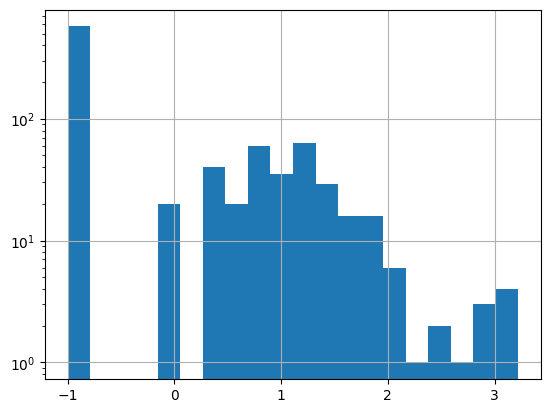

In [40]:
old_ercot["Queue Date"].sub(pd.to_datetime(old_ercot["queue_date"])).dt.total_seconds().div(60 * 60 * 24).replace(0, 1e-1).transform(np.log10).hist(bins=20, log=True)


In [41]:
mismatched_dates = (
    old_ercot["Queue Date"]
    .ne(pd.to_datetime(old_ercot["queue_date"]))
    .where((old_ercot["Queue Date"].notna() & old_ercot["queue_date"].notnull()))
).fillna(False)


In [42]:
# none of the dates match. No idea where LBNL queue date comes from. Not from the ISO data!
old_ercot.loc[mismatched_dates, [c for c in old_ercot.columns if 'date' in c.lower()]]


,Proposed Completion Date,Queue Date,Actual Completion Date,queue_date
1,2022-12-30,2013-11-13,2022-01-04,11/12/2013
91,2023-07-31,2018-10-10,2021-07-26,7/18/2018
99,2023-03-01,2018-11-30,2022-09-26,11/5/2018
106,2024-02-05,2018-12-18,NaT,12/17/2018
113,2024-11-01,2019-01-15,NaT,1/8/2019
...,...,...,...,...
1068,2026-03-24,2022-11-15,NaT,10/24/2022
1072,2026-07-01,2022-09-15,NaT,8/11/2022
1073,2026-12-01,2022-09-21,NaT,9/19/2022
1074,2027-03-24,2022-12-07,NaT,11/8/2022


In [45]:
old_ercot[['GIM Study Phase', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


GIM Study Phase                     interconnection_status_raw        
SS Completed, FIS Completed, IA     SS Completed, FIS Completed, IA       203
                                    NaN                                    19
SS Completed, FIS Completed, No IA  SS Completed, FIS Completed, No IA     46
                                    NaN                                     7
SS Completed, FIS Not Started, IA   SS Completed, FIS Not Started, IA       3
SS Completed, FIS Started, IA       SS Completed, FIS Started, IA          77
                                    NaN                                     6
SS Completed, FIS Started, No IA    SS Completed, FIS Started, No IA      520
                                    NaN                                   132
SS Started, FIS Started, No IA      SS Started, FIS Started, No IA         53
                                    NaN                                    17
NaN                                 FIS                                

In [46]:
old_ercot['GIM Study Phase'].eq(old_ercot['interconnection_status_raw']).value_counts(dropna=False)


False    1231
True      902
dtype: int64

In [48]:
# LBNL status looks consistently applied (1:1) but the ordering doesn't really make sense to me.
raw_status_match = old_ercot['GIM Study Phase'].eq(old_ercot['interconnection_status_raw'])
old_ercot.loc[raw_status_match, ['GIM Study Phase', 'interconnection_status_lbnl']].value_counts(dropna=False).sort_index()


GIM Study Phase                     interconnection_status_lbnl
SS Completed, FIS Completed, IA     IA Executed                    203
SS Completed, FIS Completed, No IA  Facility Study                  46
SS Completed, FIS Not Started, IA   System Impact Study              3
SS Completed, FIS Started, IA       IA Executed                     77
SS Completed, FIS Started, No IA    Facility Study                 520
SS Started, FIS Started, No IA      System Impact Study             53
dtype: int64

In [49]:
old_ercot.loc[raw_status_match, ['GIM Study Phase', 'queue_status']].value_counts(dropna=False).sort_index()


GIM Study Phase                     queue_status
SS Completed, FIS Completed, IA     active          202
                                    operational       1
SS Completed, FIS Completed, No IA  active           46
SS Completed, FIS Not Started, IA   active            3
SS Completed, FIS Started, IA       active           77
SS Completed, FIS Started, No IA    active          520
SS Started, FIS Started, No IA      active           53
dtype: int64

In [297]:
# also includes technology type, which is nice.
raw_ercot['Generation Type'].value_counts(dropna=False)


Other - Battery Energy Storage                                      550
Solar - Photovoltaic Solar                                          507
Wind - Wind Turbine                                                 101
Gas - Combustion (gas) Turbine, but not part of a Combined-Cycle     18
Gas - Combined-Cycle                                                 14
Gas - Internal Combustion Engine, eg. Reciprocating                   4
Other - Other                                                         4
Gas - Steam Turbine other than Combined-Cycle                         2
Other - Energy Storage                                                2
Biomass - Steam Turbine other than Combined-Cycle                     1
Name: Generation Type, dtype: int64

### NYISO

* LBNL appears to have used the column labeled `S`, which is an ordinal status number corresponding to NYISO's LFIP. Key:
  * 0=Withdrawn
  * 1=Scoping Meeting Pending
  * 2=FES Pending
  * 3=FES in Progress
  * 4=SRIS/SIS Pending
  * 5=SRIS/SIS in Progress
  * 6=SRIS/SIS Approved
  * 7=FS Pending
  * 8=Rejected Cost Allocation/Next FS Pending
  * 9=FS in Progress
  * 10=Accepted Cost Allocation/IA in Progress
  * 11=IA Completed
  * 12=Under Construction
  * 13=In Service for Test
  * 14=In Service Commercial
  * 15=Partial In-Service
* Availability of Studies  Key: None=Not Available, FES=Feasibility Study Available, SRIS=System Reliability Impact Study Available, FS=Facilities Study and/or ATRA Available
* CY Completion/SGIA Tender refers to the Attachment X milestone used to apply the 4-year COD limitation.


In [34]:
raw_nyiso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Proposed  In-Service', 'Proposed Initial-Sync Date', 'Last Updated Date', 'Z', 'S', 'Availability of Studies', 'SGIA Tender Date'], dtype='object')

In [39]:
raw_nyiso[raw_nyiso["Queue ID"].duplicated(keep=False)]

,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date
5,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Active,NaT,<NA>,None,<NA>,NaT,NaT,12/31/2019,D,12.0,"SIS, FS",None
626,0127A,Munnsville,"Airtricity Munnsville Wind Farm, LLC",Madison,NY,46kV line,NYSEG,Wind,6.0,6,<NA>,2002-10-09,Withdrawn,NaT,2014-01-31 00:00:00,None,<NA>,NaT,NaT,<NA>,E,0,None,None
1442,0127A,Munnsville,None,Madison,NY,None,NYSEG,Wind,40.0,40.0,<NA>,2002-10-09,Completed,NaT,<NA>,None,3/31/13,NaT,NaT,3/31/13,E,"11,14","SRIS, CY06",None
1517,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Completed,NaT,<NA>,None,2022-03-31 00:00:00,NaT,2021-10-01,2022-03-31 00:00:00,D,14,"SIS, FS",None


In [40]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
raw_nyiso.loc[raw_nyiso.duplicated(subset='Queue ID', keep=False), :].sort_values(by='Queue ID')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date
626,0127A,Munnsville,"Airtricity Munnsville Wind Farm, LLC",Madison,NY,46kV line,NYSEG,Wind,6.0,6,<NA>,2002-10-09,Withdrawn,NaT,2014-01-31 00:00:00,None,<NA>,NaT,NaT,<NA>,E,0,None,None
1442,0127A,Munnsville,None,Madison,NY,None,NYSEG,Wind,40.0,40.0,<NA>,2002-10-09,Completed,NaT,<NA>,None,3/31/13,NaT,NaT,3/31/13,E,"11,14","SRIS, CY06",None
5,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Active,NaT,<NA>,None,<NA>,NaT,NaT,12/31/2019,D,12.0,"SIS, FS",None
1517,0430,Cedar Rapids Transmission,None,St. Lawrence,NY,None,NM-NG,AC Transmission,0.0,<NA>,<NA>,2014-03-05,Completed,NaT,<NA>,None,2022-03-31 00:00:00,NaT,2021-10-01,2022-03-31 00:00:00,D,14,"SIS, FS",None


In [77]:
nyiso = join_lbnl(raw_nyiso.drop_duplicates(subset='Queue ID', keep='last'), lbnl, "NYISO")
nyiso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1607 entries, 0 to 1606
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Queue ID                     1533 non-null   object        
 1   Project Name                 1533 non-null   object        
 2   Interconnecting Entity       887 non-null    object        
 3   County                       1450 non-null   object        
 4   State                        1451 non-null   object        
 5   Interconnection Location     877 non-null    object        
 6   Transmission Owner           1527 non-null   object        
 7   Generation Type              1392 non-null   object        
 8   Capacity (MW)                1533 non-null   float64       
 9   Summer Capacity (MW)         1433 non-null   string        
 10  Winter Capacity (MW)         1280 non-null   string        
 11  Queue Date                   1533 non-null 

In [78]:
nyiso.head()


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Proposed In-Service,Proposed Initial-Sync Date,Last Updated Date,Z,S,Availability of Studies,SGIA Tender Date,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
0,0276,Homer Solar Energy Center,None,Cortland,NY,None,NM-NG,Solar,90.0,90.0,90.0,2008-01-30,Active,2023-09-01,<NA>,None,<NA>,NaT,2023-09-01,9/30/2022,C,10.0,"FES, SRIS, FS",None,0276,Homer Solar Energy Center,1/30/2008,active,"FES, SRIS, FS",Facility Study,90.0,Solar,True,True
1,0396,Baron Winds,None,Steuben,NY,None,NYSEG,Wind,235.0,235.0,235.0,2012-11-30,Active,2023-12-01,<NA>,None,<NA>,NaT,NaT,12/31/2022,C,15.0,"FES, SRIS, FS",None,0396,Baron Winds,11/30/2012,active,"FES, SRIS, FS",Facility Study,238.0,Wind,True,True
2,0396A,Wood Street Transformer,None,Putnam,NY,None,NYSEG,AC Transmission,0.0,<NA>,<NA>,2012-12-14,Active,NaT,<NA>,None,<NA>,NaT,NaT,4/30/2021,G,12.0,SIS,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,0422,Eight Point Wind Energy Center,None,Steuben-Allegany,NY,None,NYSEG,Wind,101.8,101.8,101.8,2013-11-07,Active,NaT,<NA>,None,<NA>,NaT,NaT,3/31/2021,C,14.0,"FES, SRIS, FS",None,0422,Eight Point Wind Energy Center,11/7/2013,active,"FES, SRIS, FS",Facility Study,102.0,Wind,True,True
4,0429,North Rockland Station,None,Steuben,NY,None,ConEd,AC Transmission,0.0,<NA>,<NA>,2014-02-12,Active,NaT,<NA>,None,<NA>,NaT,NaT,3/31/2022,G,12.0,SIS,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [79]:
nyiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       347
False  True         74
dtype: int64

In [80]:
# marginal improvement from date filter
nyiso.loc[
    nyiso["Queue Date"]
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       324
False  True         74
dtype: int64

In [81]:

nyiso[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status     queue_status
Active     active          421
           NaN             104
Completed  operational      14
           withdrawn         1
           NaN             106
Withdrawn  active           38
           withdrawn       712
           NaN             137
NaN        operational      74
dtype: int64

Why are there so many projects that have a status in GridStatus but no status in LBNL? NYISO has separate sheets for withdrawn, in service and active. Why is LBNL missing so much information?

In [82]:
nyiso.loc[
    nyiso["Queue Date"]
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["Status", "queue_status"],
].value_counts(dropna=False).sort_index()


Status     queue_status
Active     active          421
           NaN              87
Completed  operational      14
           withdrawn         1
           NaN             106
Withdrawn  active           38
           withdrawn       712
           NaN             131
NaN        operational      74
dtype: int64

In [83]:
nyiso['interconnection_status_raw'].str.replace(' ', '').replace([np.nan, None, 'None'], '').str.split(',').apply(lambda x: ','.join(sorted(set(x)))).value_counts(dropna=False)


               1376
SRIS             83
FES,SRIS         30
FS,SIS           28
FES              26
SIS              22
FS,SRIS          14
FES,FS,SRIS      13
FES,FS,SIS       12
FES,SIS           3
Name: interconnection_status_raw, dtype: int64

In [84]:
nyiso['Availability of Studies'].str.replace(r'[ \d]', '', regex=True).replace([np.nan, None, 'None'], '').str.split(',').apply(lambda x: ','.join(sorted(set(x).difference({'CY'})))).value_counts(dropna=False)


               1239
SRIS            123
SIS              52
FS,SRIS          43
FES              37
FS,SIS           36
FES,SRIS         30
FES,FS,SRIS      24
FES,FS,SIS       15
FES,SIS           4
FES,FS            2
FS                2
Name: Availability of Studies, dtype: int64

In [85]:
nyiso["simplified_studies"] = (
    nyiso["Availability of Studies"]
    .str.replace(r"[ \d]", "", regex=True)
    .replace([np.nan, None, "None"], "")
    .str.split(",")
    .apply(lambda x: ",".join(sorted(set(x).difference({"CY"}))))
    .replace('', np.nan)
)
nyiso["simplified_lbnl_raw"] = (
    nyiso["interconnection_status_raw"]
    .str.replace(" ", "")
    .replace([np.nan, None, "None"], "")
    .str.split(",")
    .apply(lambda x: ",".join(sorted(set(x))))
    .replace('', np.nan)
)


In [86]:
nyiso['S'].value_counts(dropna=False)


0        887
4.0      136
14       119
5.0       82
<NA>      74
6.0       73
10.0      49
2.0       36
11.0      33
1.0       30
8.0       29
9.0       14
3.0       12
7.0       10
12.0      10
14.0       8
13.0       2
15.0       1
12,14      1
11,14      1
Name: S, dtype: Int64

In [87]:
pd.to_numeric(nyiso['S'].astype('string').str.split(',').str[-1], errors='raise').astype(pd.UInt8Dtype()).value_counts(dropna=False)


0       887
4       136
14      129
5        82
<NA>     74
6        73
10       49
2        36
11       33
1        30
8        29
9        14
3        12
12       10
7        10
13        2
15        1
Name: S, dtype: Int64

In [88]:
nyiso["s_simplified"] = pd.to_numeric(nyiso['S'].astype('string').str.split(',').str[-1], errors='raise').astype(pd.UInt8Dtype())


In [89]:
nyiso[["queue_status", "simplified_studies"]].value_counts(dropna=False).sort_index()


queue_status  simplified_studies
active        FES                    33
              FES,FS                  1
              FES,FS,SIS             12
              FES,FS,SRIS            18
              FES,SIS                 3
              FES,SRIS               25
              FS                      1
              FS,SIS                 28
              FS,SRIS                29
              SIS                    22
              SRIS                   73
              NaN                   214
operational   FES,FS,SIS              2
              FES,FS,SRIS             2
              FS,SIS                  1
              FS,SRIS                 6
              NaN                    77
withdrawn     SRIS                    1
              NaN                   712
NaN           FES                     4
              FES,FS                  1
              FES,FS,SIS              1
              FES,FS,SRIS             4
              FES,SIS                 1
       

In [90]:
nyiso[["simplified_lbnl_raw", "simplified_studies"]].value_counts(dropna=False).sort_index()


simplified_lbnl_raw  simplified_studies
FES                  FES                     21
                     FES,SRIS                 4
                     NaN                      1
FES,FS,SIS           FES,FS,SIS              11
                     FS,SIS                   1
FES,FS,SRIS          FES,FS,SRIS             12
                     NaN                      1
FES,SIS              FES,SIS                  2
                     SIS                      1
FES,SRIS             FES,FS                   1
                     FES,FS,SRIS              6
                     FES,SRIS                20
                     NaN                      3
FS,SIS               FES,FS,SIS               1
                     FS,SIS                  26
                     NaN                      1
FS,SRIS              FS,SRIS                 14
SIS                  FES,SIS                  1
                     FS,SIS                   1
                     SIS                     20


In [91]:
nyiso["simplified_lbnl_raw"].astype('string').eq(nyiso["simplified_studies"].astype('string')).value_counts(dropna=False)


<NA>     1393
True      181
False      33
dtype: Int64

In [92]:
nyiso[["queue_status", "s_simplified"]].value_counts(dropna=False).sort_index()


queue_status  s_simplified
active        0                38
              1                 2
              2                25
              3                12
              4               112
              5                57
              6                70
              7                10
              8                29
              9                14
              10               44
              11               33
              12                4
              13                2
              14                6
              15                1
operational   14               14
              <NA>             74
withdrawn     0               712
              14                1
NaN           0               137
              1                28
              2                11
              4                24
              5                25
              6                 3
              10                5
              12                6
              14     

In [93]:
nyiso[["s_simplified", "simplified_studies"]].value_counts(dropna=False).sort_index()


s_simplified  simplified_studies
0             NaN                   887
1             NaN                    30
2             NaN                    36
3             NaN                    12
4             FES                    22
              NaN                   114
5             FES                    14
              NaN                    68
6             FES,SRIS               16
              SIS                     4
              SRIS                   53
7             FES,SIS                 1
              SIS                     6
              SRIS                    3
8             FES,SIS                 2
              FES,SRIS                9
              SIS                     3
              SRIS                   15
9             SIS                    11
              SRIS                    3
10            FES,FS                  1
              FES,FS,SIS              3
              FES,FS,SRIS            11
              FS                      1
       

In [94]:
nyiso[["s_simplified", "simplified_lbnl_raw"]].value_counts(dropna=False).sort_index()


s_simplified  simplified_lbnl_raw
0             FES                      1
              FES,FS,SRIS              1
              FES,SRIS                 3
              SRIS                    11
              NaN                    871
1             NaN                     30
2             NaN                     36
3             NaN                     12
4             FES                     14
              NaN                    122
5             FES                      7
              NaN                     75
6             FES                      4
              FES,SRIS                12
              SIS                      2
              SRIS                    34
              NaN                     21
7             SIS                      6
              SRIS                     3
              NaN                      1
8             FES,SIS                  2
              FES,SRIS                 8
              SIS                      3
              SRIS     

In [95]:
nyiso[["interconnection_status_lbnl", "s_simplified"]].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  s_simplified
Facility Study               0                 1
                             10               21
                             11               33
                             12                4
                             13                1
                             14                6
                             15                1
Feasibility Study            0                 1
                             4                14
                             5                 7
                             6                 4
In Progress (unknown study)  0                22
                             1                 2
                             2                25
                             3                12
                             4                98
                             5                50
                             6                18
                             7                 1
Operational                

In [96]:
nyiso["Queue Date"].eq(pd.to_datetime(nyiso["queue_date"])).where(
    (nyiso["Queue Date"].notna() & nyiso["queue_date"].notnull())
).value_counts(dropna=False)


True     1185
NaN       421
False       1
dtype: int64

In [97]:
# needs standardization
raw_nyiso['Generation Type'].value_counts(dropna=False)


Energy Storage                                      369
Solar                                               366
Wind                                                267
AC Transmission                                     144
None                                                141
DC Transmission                                      46
Combustion Turbine                                   46
Combined Cycle                                       35
Methane                                              24
Hydro                                                18
Load                                                 16
Natural Gas                                          12
Steam Turbine                                        11
Pumped Storage                                        8
Fuel Cell                                             8
Nuclear                                               6
Dual Fuel                                             5
Wood                                            

### NYISO Capacity Comparison
- Compare total capacity for projects in lbnl and gs
- Compare total capacity for active projects in lbnl and gs
- Compare total capacity for active projects
- Compare capacity by fuel type? Might challenging because the categories are all over the place

#### Compare total capacity for projects in both

In [98]:
both_nyiso = nyiso[nyiso.in_lbnl & nyiso.in_gs].copy()
print(nyiso.shape)
print(both_nyiso.shape)

(1607, 37)
(1186, 37)


In [99]:
both_nyiso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186 entries, 0 to 1531
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Queue ID                     1186 non-null   object        
 1   Project Name                 1186 non-null   object        
 2   Interconnecting Entity       750 non-null    object        
 3   County                       1107 non-null   object        
 4   State                        1107 non-null   object        
 5   Interconnection Location     740 non-null    object        
 6   Transmission Owner           1180 non-null   object        
 7   Generation Type              1053 non-null   object        
 8   Capacity (MW)                1186 non-null   float64       
 9   Summer Capacity (MW)         1180 non-null   string        
 10  Winter Capacity (MW)         1065 non-null   string        
 11  Queue Date                   1186 non-null 

In [108]:
gs_nyiso_cap = both_nyiso["Capacity (MW)"].sum()
lbnl_nyiso_cap = both_nyiso["capacity_mw_resource_1"].sum()

print(gs_nyiso_cap)
print(lbnl_nyiso_cap)
print(lbnl_nyiso_cap / gs_nyiso_cap)

226128.46
228118.59999999998
1.008800926694499


Ok! Projects that exist in both have very similar total capacities! That's a good start. I could look into which projects have different capacity values but the amount is so minor that I'm going to skip for now.

#### Compare total capacity for **active** projects in both

In [115]:
both_nyiso["queue_status"].value_counts()

withdrawn      713
active         459
operational     14
Name: queue_status, dtype: int64

In [130]:
both_nyiso[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Withdrawn  withdrawn       712
Active     active          421
Withdrawn  active           38
Completed  operational      14
           withdrawn         1
dtype: int64

There are some active LBNL projects that have been withdrawn maybe because the GS data is a bit fresher? If so the withdrawl dates should be after 2022-12-31.

In [123]:
pd.to_datetime(both_nyiso[(both_nyiso["Status"] == "Withdrawn") & (both_nyiso["queue_status"] == "active")]["Withdrawn Date"]).dt.year.value_counts()

2023    38
Name: Withdrawn Date, dtype: int64

Great! That explains it. This means we can just compare projects marked active in lbnl

In [126]:
active_both_nyiso = both_nyiso[(both_nyiso["queue_status"] == "active")]
gs_nyiso_cap = active_both_nyiso["Capacity (MW)"].sum()
lbnl_nyiso_cap = active_both_nyiso["capacity_mw_resource_1"].sum()

print(gs_nyiso_cap)
print(lbnl_nyiso_cap)
print(lbnl_nyiso_cap / gs_nyiso_cap)

108584.66
110592.0
1.0184864049857503


Similar capacity totals I'm comfortable with.

#### Compare total capacity for all projects

In [128]:
nyiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1186
       False       347
False  True         74
dtype: int64

In [129]:
nyiso[["Status", "queue_status"]].value_counts(dropna=False)

Status     queue_status
Withdrawn  withdrawn       712
Active     active          421
Withdrawn  NaN             137
Completed  NaN             106
Active     NaN             104
NaN        operational      74
Withdrawn  active           38
Completed  operational      14
           withdrawn         1
dtype: int64

In [143]:
print(nyiso[nyiso.in_gs & ~nyiso.in_lbnl]["Capacity (MW)"].sum() / nyiso[nyiso.in_gs]["Capacity (MW)"].sum())
print(nyiso[~nyiso.in_gs & nyiso.in_lbnl]["capacity_mw_resource_1"].sum() / nyiso[nyiso.in_lbnl]["Capacity (MW)"].sum())

0.2705746493529786
0.04379634478561434


Projects in GS but not in lbnl account for 27% of total capacity in GS nyiso.
Projects in LBNL but not in GS account for 4% of total capacity in LBNL NYISO.

Why does GS have so much more capacity than LBNL here? Do we care if GS has more capacity than LBNL given GS more closely resembles the source data? Is LBNL doing deduplication work behind the scenes?

### MISO
Very good project coverage, but the IA status categories are a mess.

In [144]:
raw_miso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'facilityType', 'Post Generator Interconnection Agreement Status', 'Interconnection Approval Date', 'inService', 'giaToExec', 'studyCycle', 'studyGroup', 'studyPhase', 'svcType', 'dp1ErisMw', 'dp1NrisMw', 'dp2ErisMw', 'dp2NrisMw', 'sisPhase1'], dtype='object')

In [145]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
# Nearly whole-row duplicate, except for "studyPhase"
raw_miso.loc[raw_miso.duplicated(subset='Queue ID', keep=False), :].sort_values(by='Queue ID')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,facilityType,Post Generator Interconnection Agreement Status,Interconnection Approval Date,inService,giaToExec,studyCycle,studyGroup,studyPhase,svcType,dp1ErisMw,dp1NrisMw,dp2ErisMw,dp2NrisMw,sisPhase1
2213,J392,None,None,Otsego County,MI,ITC/METC 138 kV Livingston to Stover line,"Michigan Electric Transmission Company, LLC",Gas,420.7,383.1,420.7,2014-09-15T04:00:00Z,Done,2015-09-01T04:00:00Z,None,None,None,CT Combustion Turbine (Simple Cycle),In Service,2016-03-23T04:00:00Z,2016-05-16T04:00:00Z,2016-03-23T04:00:00Z,DPP-2015-FEB,East (ITC),Network Upgrade,NRIS,0.0,0.0,0.0,0.0,
2214,J392,None,None,Otsego County,MI,ITC/METC 138 kV Livingston to Stover line,"Michigan Electric Transmission Company, LLC",Gas,420.7,383.1,420.7,2014-09-15T04:00:00Z,Done,2015-09-01T04:00:00Z,None,None,None,CT Combustion Turbine (Simple Cycle),In Service,2016-03-23T04:00:00Z,2016-05-16T04:00:00Z,2016-03-23T04:00:00Z,DPP-2015-FEB,East (ITC),Int FaS,NRIS,0.0,0.0,0.0,0.0,


In [146]:
# I don't know which is correct (if either), but I'll guess that the later one is. So keep='last'
# Nearly whole-row duplicate, except for "studyPhase"
lbnl.query('entity == "MISO"').loc[lbnl.query('entity == "MISO"').duplicated(subset='queue_id', keep=False), :].sort_values(by='queue_id')


,queue_id,queue_status,queue_date,queue_year,interconnection_date,entity,project_name,developer,utility,county_1,county_2,county_3,raw_state_name,region,interconnection_service_type,point_of_interconnection,date_proposed,year_proposed,interconnection_status_raw,interconnection_status_lbnl,resource_type_lbnl,resource_type_1,resource_type_2,resource_type_3,capacity_mw_resource_1,capacity_mw_resource_2,capacity_mw_resource_3
10519,J392,operational,9/15/2014,2014.0,3/23/2016,MISO,NaN,NaN,"Michigan Electric Transmission Company, LLC",otsego,NaN,NaN,MI,MISO,NRIS,ITC/METC 138 kV Livingston to Stover line,5/16/2016,2016.0,In Service,Operational,Gas,Gas,NaN,NaN,421.0,NaN,NaN
10842,J392,operational,9/15/2014,2014.0,3/23/2016,MISO,NaN,NaN,"Michigan Electric Transmission Company, LLC",otsego,NaN,NaN,MI,MISO,NRIS,ITC/METC 138 kV Livingston to Stover line,5/16/2016,2016.0,In Service,Operational,Gas,Gas,NaN,NaN,421.0,NaN,NaN


In [147]:
miso = join_lbnl(raw_miso.drop_duplicates(subset='Queue ID', keep='last'), lbnl.query('entity == "MISO"').drop_duplicates(subset='queue_id', keep='last'), "MISO")
miso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4252 entries, 0 to 4251
Data columns (total 41 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Queue ID                                         4252 non-null   object 
 1   Project Name                                     0 non-null      object 
 2   Interconnecting Entity                           0 non-null      object 
 3   County                                           4252 non-null   object 
 4   State                                            4252 non-null   object 
 5   Interconnection Location                         4252 non-null   object 
 6   Transmission Owner                               4252 non-null   object 
 7   Generation Type                                  4252 non-null   object 
 8   Capacity (MW)                                    4252 non-null   float64
 9   Summer Capacity (MW)          

In [148]:
miso.sample(4)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,facilityType,Post Generator Interconnection Agreement Status,Interconnection Approval Date,inService,giaToExec,studyCycle,studyGroup,studyPhase,svcType,dp1ErisMw,dp1NrisMw,dp2ErisMw,dp2NrisMw,sisPhase1,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,capacity_mw_resource_1,resource_type_1,in_lbnl,in_gs
3994,J3095,None,None,Ford,IL,4PAXTON E - 4GIFFORD 138 KV,Ameren Illinois,Solar,200.0,200.0,200.0,2022-11-03T04:00:00Z,Active,None,None,None,None,PV Photovoltaic,Not Started,None,2025-09-01T04:00:00Z,None,DPP-2022-Cycle,Central,Study Not Started,NRIS,0.0,0.0,0.0,0.0,,J3095,NaN,11/3/2022,active,not started,Not Started,200.0,Solar,True,True
1606,J1148,None,None,Posey County,IN,AB Brown 138 kV Substation,Southern Indiana Gas & Electric Company d/b/a ...,Gas,54.0,54.0,54.0,2018-03-12T04:00:00Z,Withdrawn,None,2020-01-07T05:00:00Z,None,None,Combined Cycle,Not Started,None,2022-06-01T04:00:00Z,None,DPP-2018-APR,Central,PHASE 3,NRIS,0.0,0.0,0.0,0.0,,J1148,NaN,3/12/2018,withdrawn,Facility Study,Facility Study,54.0,Gas,True,True
1380,G423,None,None,Columbia County,WI,Unknown,American Transmission Co. LLC,Wind,19.0,19.0,19.0,2004-04-07T04:00:00Z,Withdrawn,2006-12-01T05:00:00Z,2004-09-09T04:00:00Z,None,None,WT Wind Turbine,Not Started,2004-09-09T04:00:00Z,None,None,,,,ERIS,0.0,0.0,0.0,0.0,,G423,NaN,4/7/2004,withdrawn,Withdrawn,Withdrawn,19.0,Wind,True,True
1568,J1113,None,None,Sunflower County,MS,Delta - Ruleville 115kV Line Tap,"Entergy Mississippi, LLC",Solar,85.0,85.0,85.0,2018-03-12T04:00:00Z,Withdrawn,None,2019-08-29T04:00:00Z,None,None,PV Photovoltaic,Not Started,None,2022-09-01T04:00:00Z,None,DPP-2018-APR,South,GIA,NRIS,0.0,0.0,0.0,0.0,,J1113,NaN,3/12/2018,withdrawn,IA Executed,IA Executed,85.0,Solar,True,True


In [149]:
miso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       4070
       False       182
dtype: int64

In [150]:
# somehow makes things worse?
miso.loc[
    pd.to_datetime(miso["Queue Date"].str.replace(r'\d{2}:\d{2}:\d{2}Z$', '', regex=True))  # remove time
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       3928
       False       169
dtype: int64

In [151]:
pd.to_datetime(miso["Queue Date"].str.replace(r'\d{2}:\d{2}:\d{2}Z$', '', regex=True)).describe()


/tmp/ipykernel_107/346163862.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(miso["Queue Date"].str.replace(r'\d{2}:\d{2}:\d{2}Z$', '', regex=True)).describe()


count                    3962
unique                   1166
top       2019-04-29 00:00:00
freq                      257
first     1900-01-01 00:00:00
last      2023-04-03 00:00:00
Name: Queue Date, dtype: object

In [152]:
pd.to_datetime(miso['queue_date']).describe()


/tmp/ipykernel_107/2725150268.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(miso['queue_date']).describe()


count                    4056
unique                   1133
top       2019-04-29 00:00:00
freq                      239
first     1995-11-08 00:00:00
last      2022-12-21 00:00:00
Name: queue_date, dtype: object

In [153]:
miso[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status                    queue_status
                          NaN                1
Active                    active          1324
                          withdrawn          1
                          NaN              122
Done                      active           294
                          operational      449
                          withdrawn         51
                          NaN               15
Withdrawn                 active           116
                          operational        2
                          withdrawn       1831
                          NaN               44
Withdrawn - Pending Cure  withdrawn          2
dtype: int64

In [154]:
miso[['queue_status', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


queue_status  interconnection_status_raw
active        Active                        817
              Facility Study                150
              Feasibility Study              80
              IA Executed                   236
              System Impact Study            75
              not started                   376
operational   In Service                    451
withdrawn     Facility Study                291
              Feasibility Study             370
              IA Executed                   312
              System Impact Study           497
              Withdrawn                     264
              not started                    57
              unknown                        94
NaN           NaN                           182
dtype: int64

In [155]:
miso['interconnection_status_lbnl'].value_counts(dropna=False)


In Progress (unknown study)    911
System Impact Study            572
IA Executed                    548
Operational                    451
Feasibility Study              450
Facility Study                 441
Not Started                    433
Withdrawn                      264
NaN                            182
Name: interconnection_status_lbnl, dtype: int64

In [156]:
miso.loc[:, ['studyPhase', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


studyPhase         interconnection_status_raw
                   Active                         13
                   IA Executed                    28
                   In Service                     32
                   Withdrawn                     260
                   not started                     2
                   NaN                             5
DPP - SIS          IA Executed                    11
                   In Service                    108
                   System Impact Study            88
                   NaN                             1
Feasibility        Feasibility Study             334
                   IA Executed                     3
                   In Service                      6
GIA                IA Executed                   356
                   In Service                     78
                   NaN                             1
Int FaS            Facility Study                 12
                   In Service                      6


In [157]:
miso.loc[:, ['studyPhase', 'interconnection_status_lbnl']].value_counts(dropna=False).sort_index()


studyPhase         interconnection_status_lbnl
                   IA Executed                     28
                   In Progress (unknown study)     13
                   Not Started                      2
                   Operational                     32
                   Withdrawn                      260
                   NaN                              5
DPP - SIS          IA Executed                     11
                   Operational                    108
                   System Impact Study             88
                   NaN                              1
Feasibility        Feasibility Study              334
                   IA Executed                      3
                   Operational                      6
GIA                IA Executed                    356
                   Operational                     78
                   NaN                              1
Int FaS            Facility Study                  12
                   Operational     

In [158]:
# inconsistent mix of fuel/tech type
raw_miso['Generation Type'].value_counts(dropna=False)


Solar                  1479
Wind                   1364
Battery Storage         456
Hybrid                  272
Gas                     233
                        143
Coal                    100
Combined Cycle           57
Diesel                   36
Hydro                    28
Nuclear                  26
Biomass                  22
Wood                     10
Waste Heat Recovery       8
Landfill Gas              8
High Voltage DC           8
Co-Gen                    2
Steam                     1
Name: Generation Type, dtype: int64

### SPP

* neither LBNL nor GridStatus have withdrawn projects
* GridStatus destroys the detailed status information during their processing, so we lose the ability to distinguish between "IA pending" and "System Integration Study". But I don't think that is a problem because both are included in the "actionable" criteria in Synapse's model.

In [142]:
raw_spp.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'In-Service Date', 'Commercial Operation Date', 'Cessation Date', 'Current Cluster', 'Cluster Group', 'Replacement Generator Commercial Op Date', 'Service Type'], dtype='object')

In [143]:
spp = join_lbnl(raw_spp, lbnl, "SPP")
spp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 0 to 964
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Queue ID                                  950 non-null    object 
 1   Project Name                              0 non-null      object 
 2   Interconnecting Entity                    0 non-null      object 
 3   County                                    945 non-null    object 
 4   State                                     946 non-null    object 
 5   Interconnection Location                  933 non-null    object 
 6   Transmission Owner                        942 non-null    object 
 7   Generation Type                           950 non-null    object 
 8   Capacity (MW)                             950 non-null    float64
 9   Summer Capacity (MW)                      950 non-null    float64
 10  Winter Capacity (MW)                  

In [144]:
spp.sample(4)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,In-Service Date,Commercial Operation Date,Cessation Date,Current Cluster,Cluster Group,Replacement Generator Commercial Op Date,Service Type,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,in_lbnl,in_gs
417,GEN-2020-017,None,None,Lamb County,TX,230kV Lamb County Interchange,SPS,Solar,74.88,74.88,74.88,4/24/2020,Active,12/31/2025,None,None,None,10/1/2025,12/31/2025,None,DISIS-2020-001,05 SOUTHWEST,None,ER/NR,GEN-2020-017,NaN,4/24/2020,active,DISIS STAGE,System Impact Study,True,True
596,GEN-2017-167,None,None,Carter,OK,Sunnyside 345kV,OGE,Battery/Storage,52.00,52.00,52.00,11/29/2017,None,12/1/2025,None,None,None,12/31/2020,12/1/2025,None,DISIS-2017-002,04 SOUTHEAST,None,ER/NR,GEN-2017-167,NaN,11/29/2017,active,DISIS STAGE,System Impact Study,True,True
610,GEN-2017-140,None,None,Wagoner,OK,Clarksville 345kV Switching Station,AEP,Solar,160.00,160.00,160.00,11/22/2017,None,12/30/2025,None,None,None,12/1/2020,12/30/2025,None,DISIS-2017-002,04 SOUTHEAST,None,ER/NR,GEN-2017-140,NaN,11/22/2017,active,DISIS STAGE,System Impact Study,True,True
87,GEN-2022-178,None,None,Tillman,OK,Oklaunion to Lawton 345 kV Transmission Line a...,AEP,Solar,225.00,225.00,225.00,2/27/2023,Active,12/31/2026,None,None,None,12/31/2026,12/31/2026,None,DISIS-2022-001,04 SOUTHEAST,None,ER/NR,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [145]:
spp[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       787
       False      163
False  True        15
dtype: int64

In [147]:
spp.loc[
    pd.to_datetime(spp["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       785
False  True        15
True   False        8
dtype: int64

In [148]:
spp[["Status", "queue_status"]].value_counts(dropna=False)


Status     queue_status
Active     active          391
Completed  operational     240
Active     NaN             166
Completed  active           87
NaN        active           78
           NaN               2
Completed  suspended         1
dtype: int64

In [149]:
spp.loc[
    pd.to_datetime(spp["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["Status", "queue_status"],
].value_counts(dropna=False)


Status     queue_status
Active     active          389
Completed  operational     240
           active           87
NaN        active           78
Active     NaN              11
NaN        NaN               2
Completed  suspended         1
dtype: int64

In [150]:
# it turns out these values come from the raw "status" values, which GridStatus overwrites 😡
spp['interconnection_status_raw'].value_counts(dropna=False)


DISIS STAGE                               454
IA FULLY EXECUTED/COMMERCIAL OPERATION    240
NaN                                       163
IA FULLY EXECUTED/ON SCHEDULE              88
FACILITY STUDY STAGE                       13
None                                        5
IA PENDING                                  1
IA FULLY EXECUTED/ON SUSPENSION             1
Name: interconnection_status_raw, dtype: int64

In [155]:
spp[['interconnection_status_lbnl', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  interconnection_status_raw            
Facility Study               FACILITY STUDY STAGE                       13
                             IA PENDING                                  1
IA Executed                  IA FULLY EXECUTED/ON SCHEDULE              88
In Progress (unknown study)  None                                        5
Operational                  IA FULLY EXECUTED/COMMERCIAL OPERATION    240
Suspended                    IA FULLY EXECUTED/ON SUSPENSION             1
System Impact Study          DISIS STAGE                               454
NaN                          NaN                                       163
dtype: int64

In [152]:
spp['Current Cluster'].str.replace(r'-\d{4}-\d{3}(?:-\d)?', '', regex=True).value_counts(dropna=False)  # remove date/ID


DISIS                 840
ICS Prior Queued       43
None                   35
Surplus                20
NaN                    15
ICS                    11
DISIS Prior Queued      1
Name: Current Cluster, dtype: int64

In [157]:
spp['cluster_simplified'] = spp['Current Cluster'].str.replace(r'-\d{4}-\d{3}(?:-\d)?', '', regex=True) # remove date/ID


In [159]:
spp[['interconnection_status_raw', 'cluster_simplified']].value_counts(dropna=False).sort_index()


interconnection_status_raw              cluster_simplified
DISIS STAGE                             DISIS                 442
                                        NaN                    12
FACILITY STUDY STAGE                    DISIS                  13
IA FULLY EXECUTED/COMMERCIAL OPERATION  DISIS                 154
                                        DISIS Prior Queued      1
                                        ICS                    11
                                        ICS Prior Queued       43
                                        NaN                    31
IA FULLY EXECUTED/ON SCHEDULE           DISIS                  82
                                        Surplus                 5
                                        NaN                     1
IA FULLY EXECUTED/ON SUSPENSION         DISIS                   1
IA PENDING                              DISIS                   1
None                                    NaN                     5
NaN              

In [ ]:
spp[['interconnection_status_lbnl', 'cluster_simplified']].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  cluster_simplified
Facility Study               DISIS                  14
IA Executed                  DISIS                  82
                             Surplus                 5
                             NaN                     1
In Progress (unknown study)  NaN                     5
Operational                  DISIS                 154
                             DISIS Prior Queued      1
                             ICS                    11
                             ICS Prior Queued       43
                             NaN                    31
Suspended                    DISIS                   1
System Impact Study          DISIS                 442
                             NaN                    12
NaN                          DISIS                 147
                             Surplus                15
                             NaN                     1
dtype: int64

In [300]:
# needs standardization
raw_spp['Generation Type'].value_counts(dropna=False)


Wind                              364
Solar                             253
Battery/Storage                   166
Hybrid - Solar/Storage             58
Thermal - Gas                      24
Thermal - CT                       24
Thermal - Coal                      8
                                    6
Hydro                               6
Hybrid - Solar                      5
Thermal - Nuclear                   4
Hybrid - Solar/Battery              4
Thermal - Gas Turbine               4
Thermal                             4
Hybrid - Wind/Storage               4
Thermal - CTG                       3
Thermal - Reciprocating Engine      3
WIND                                2
Thermal - CC                        1
Thermal - NG/CT                     1
Thermal - Diesel/Gas                1
Thermal - Steam Turbine             1
Battery/Storage - WERE              1
Thermal - Combined Cycle            1
Hybrid                              1
Thermal - CT/ST                     1
Name: Genera

### PJM
Like MISO, good project coverage, but the IA status categories are a mess.

"Active" applied up to IA execution. Then "Engineering and Procurement" applied to IA execution through COD. Then "In Service".

In [160]:
raw_pjm.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'MW In Service', 'Commercial Name', 'Initial Study', 'Feasibility Study', 'Feasibility Study Status', 'System Impact Study', 'System Impact Study Status', 'Facilities Study', 'Facilities Study Status', 'Interim Interconnection Service Agreement', 'Interim/Interconnection Service Agreement Status', 'Wholesale Market Participation Agreement', 'Construction Service Agreement', 'Construction Service Agreement Status', 'Upgrade Construction Service Agreement', 'Upgrade Construction Service Agreement Status', 'Backfeed Date', 'Long-Term Firm Service Start Date', 'Long-Term Firm Service End Date', 'Test Energy Date'], dtype='object')

In [292]:
# "Active" stops at IA execution
raw_pjm[['Interim/Interconnection Service Agreement Status', 'Status']].value_counts(dropna=False).sort_index()


Interim/Interconnection Service Agreement Status  Status                                   
Document Posted                                   Active                                          3
                                                  Deactivated                                    46
                                                  Engineering and Procurement                   240
                                                  In Service                                    839
                                                  Partially in Service - Under Construction      47
                                                  Suspended                                      47
                                                  Under Construction                             38
                                                  Withdrawn                                     206
Interim Study                                     Active                                         20
        

In [161]:
pjm = join_lbnl(raw_pjm, lbnl, "PJM")
pjm.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9030 entries, 0 to 9029
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Queue ID                                          9030 non-null   object 
 1   Project Name                                      8806 non-null   object 
 2   Interconnecting Entity                            0 non-null      object 
 3   County                                            8168 non-null   object 
 4   State                                             8225 non-null   object 
 5   Interconnection Location                          0 non-null      object 
 6   Transmission Owner                                8312 non-null   object 
 7   Generation Type                                   8045 non-null   object 
 8   Capacity (MW)                                     8806 non-null   float64
 9   Summer Capacity (MW

In [162]:
pjm.sample(4)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,MW In Service,Commercial Name,Initial Study,Feasibility Study,Feasibility Study Status,System Impact Study,System Impact Study Status,Facilities Study,Facilities Study Status,Interim Interconnection Service Agreement,Interim/Interconnection Service Agreement Status,Wholesale Market Participation Agreement,Construction Service Agreement,Construction Service Agreement Status,Upgrade Construction Service Agreement,Upgrade Construction Service Agreement Status,Backfeed Date,Long-Term Firm Service Start Date,Long-Term Firm Service End Date,Test Energy Date,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,in_lbnl,in_gs
3969,AC1-142A,Joliet,None,Will,IL,None,ComEd,Natural Gas,64.0,64.0,64.0,10/28/2016,In Service,12/31/2020,None,None,12/8/2020,64.0,Joliet Units 7 and 8,None,https://www.pjm.com/pub/planning/project-queue...,Document Posted,https://www.pjm.com/pub/planning/project-queue...,Document Posted,None,Not Required,https://www.pjm.com/pub/planning/project-queue...,Document Posted,None,None,Not Required,None,None,None,None,None,None,AC1-142A,Joliet Units 7 and 8,10/28/2016,operational,IA Executed,IA Executed,True,True
8947,533213,None,None,None,None,None,None,None,NaN,NaN,NaN,None,Confirmed,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,6/1/2007,6/1/2008,None,NaN,NaN,NaN,NaN,NaN,NaN,False,True
7547,AH1-296,Lanesville-Brokaw 345 kV,None,Logan,IL,None,ComEd,Storage,660.0,60.0,60.0,9/10/2021,Active,None,None,None,None,NaN,None,None,None,In Progress,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,AH1-296,NaN,9/10/2021,active,In Progress,Feasibility Study,True,True
5092,AE2-208,Chavies-Bonnyman 69 kV,None,Perry,KY,None,AEP,Storage,80.0,25.0,25.0,3/20/2019,Withdrawn,None,3/27/2020,None,None,NaN,None,None,https://www.pjm.com/pub/planning/project-queue...,Document Posted,https://www.pjm.com/pub/planning/project-queue...,Document Posted,None,None,None,None,None,None,None,None,None,None,None,None,None,AE2-208,NaN,3/20/2019,withdrawn,System Impact Study,System Impact Study,True,True


In [172]:
pjm['Wholesale Market Participation Agreement'].value_counts(dropna=False)


None                                                                    8343
https://www.pjm.com/pub/planning/project-queues/wmpa/ac2168_wmpa.pdf       1
https://www.pjm.com/pub/planning/project-queues/wmpa/ac2136_wmpa.pdf       1
https://www.pjm.com/pub/planning/project-queues/wmpa/ac2137_wmpa.pdf       1
https://www.pjm.com/pub/planning/project-queues/wmpa/ac2138_wmpa.pdf       1
                                                                        ... 
https://www.pjm.com/pub/planning/project-queues/wmpa/x2035_wmpa.pdf        1
https://www.pjm.com/pub/planning/project-queues/wmpa/x2038_wmpa.pdf        1
https://www.pjm.com/pub/planning/project-queues/wmpa/x2054_wmpa.pdf        1
https://www.pjm.com/pub/planning/project-queues/wmpa/x2059_wmpa.pdf        1
https://www.pjm.com/pub/planning/project-queues/wmpa/ah1109_wmpa.pdf       1
Name: Wholesale Market Participation Agreement, Length: 688, dtype: int64

In [175]:
# no status column for this one for some reason
pjm['wholesale_not_none'] = pjm['Wholesale Market Participation Agreement'].notna()


In [163]:
pjm[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       7738
       False      1292
dtype: int64

In [164]:
pjm.loc[
    pd.to_datetime(pjm["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       7738
       False       966
dtype: int64

In [167]:
pjm[["queue_status", "Status"]].value_counts(dropna=False).sort_index()


queue_status  Status                                   
active        Active                                       2587
              Engineering and Procurement                   337
              In Service                                     11
              Partially in Service - Under Construction       6
              Suspended                                      18
              Under Construction                             52
              Withdrawn                                      31
operational   Deactivated                                     2
              In Service                                   1008
              Partially in Service - Under Construction      50
              Withdrawn                                       1
suspended     Engineering and Procurement                    12
              Suspended                                      65
withdrawn     Deactivated                                    55
              Withdrawn                         

In [171]:
pjm['interconnection_status_raw'].value_counts(dropna=False)


System Impact Study    2351
In Progress            1723
IA Executed            1398
NaN                    1292
Feasibility Study      1241
Withdrawn               698
Facility Study          279
Not Required             41
0                         7
Name: interconnection_status_raw, dtype: int64

In [189]:
# lots of IA status info encoded in various status columns. Have to figure out how to reconstruct the LBNL definitions
status_cols = [
    'Feasibility Study Status',
    'System Impact Study Status',
    'Facilities Study Status',
    'Interim/Interconnection Service Agreement Status',
    # 'wholesale_not_none',  # redundant with IA status "Wholesale Market Participation Agreement"
    'Construction Service Agreement Status',
    'Upgrade Construction Service Agreement Status'
]
with pd.option_context('display.max_rows', None):
    display(pjm.loc[pjm['queue_status'].eq('active'), status_cols[:4] + ['interconnection_status_lbnl']].value_counts(dropna=False).sort_index())


Feasibility Study Status  System Impact Study Status  Facilities Study Status  Interim/Interconnection Service Agreement Status  interconnection_status_lbnl
Document Posted           Document Posted             Document Posted          Document Posted                                   Facility Study                   33
                                                                                                                                 IA Executed                     202
                                                                                                                                 System Impact Study              17
                                                                               Interim Study                                     System Impact Study               2
                                                                               Wholesale Market Participation Agreement          Facility Study                    8
                  

In [301]:
# needs standardization. Also has a long tail of multivalued entries.
raw_pjm['Generation Type'].value_counts(dropna=False)


Solar                                  3882
Natural Gas                            1099
Storage                                1017
None                                    985
Wind                                    724
Solar; Storage                          552
Methane                                 191
Coal                                    137
Hydro                                    95
Offshore Wind                            79
Nuclear                                  73
Biomass                                  51
Oil                                      51
Other                                    27
Diesel                                   24
Storage; Solar                           12
Wood                                      6
Natural Gas; Other                        6
Wind; Storage                             3
Diesel; Methane                           2
Solar; Wind                               2
Natural Gas; Other; Storage; Solar        2
Natural Gas; Solar; Other       

### CAISO
Straightforward!

In [206]:
raw_caiso.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Type-1', 'Type-2', 'Type-3', 'Fuel-1', 'Fuel-2', 'Fuel-3', 'MW-1', 'MW-2', 'MW-3', 'Interconnection Request Receive Date', 'Interconnection Agreement Status', 'Study Process', 'Proposed On-line Date (as filed with IR)', 'System Impact Study or Phase I Cluster Study', 'Facilities Study (FAS) or Phase II Cluster Study', 'Optional Study (OS)', 'Full Capacity, Partial or Energy Only (FC/P/EO)', 'Off-Peak Deliverability and Economic Only', 'Feasibility Study or Supplemental Review'], dtype='object')

In [190]:
caiso = join_lbnl(raw_caiso, lbnl, "CAISO")
caiso.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2277
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Queue ID                                          2278 non-null   object        
 1   Project Name                                      2278 non-null   object        
 2   Interconnecting Entity                            0 non-null      object        
 3   County                                            2273 non-null   object        
 4   State                                             2274 non-null   object        
 5   Interconnection Location                          2278 non-null   object        
 6   Transmission Owner                                2278 non-null   object        
 7   Generation Type                                   2278 non-null   object        
 8   Capacity (MW)               

In [205]:
caiso.query("Status == 'ACTIVE'").sample(8, random_state=42).sort_values('interconnection_status_lbnl')


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Type-1,Type-2,Type-3,Fuel-1,Fuel-2,Fuel-3,MW-1,MW-2,MW-3,Interconnection Request Receive Date,Interconnection Agreement Status,Study Process,Proposed On-line Date (as filed with IR),System Impact Study or Phase I Cluster Study,Facilities Study (FAS) or Phase II Cluster Study,Optional Study (OS),"Full Capacity, Partial or Energy Only (FC/P/EO)",Off-Peak Deliverability and Economic Only,Feasibility Study or Supplemental Review,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,in_lbnl,in_gs
30,1048,ESCONDIDO ENERGY CENTER 2,None,SAN DIEGO,CA,Escondido Substation 69 kV,SDGE,Storage,50.0,None,None,2014-04-30 07:00:00,ACTIVE,2025-07-17 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,50.0000,NaN,NaN,2014-04-30,In Progress,C07,2019-11-01 07:00:00,Complete,Complete,None,Energy Only,None,None,1048,ESCONDIDO ENERGY CENTER 2,4/30/2014,active,Facilities,Facility Study,True,True
204,1736,HAWKINS SOLAR HYBRID,None,KERN,CA,ARCO Substation 230kV,PGAE,Photovoltaic + Storage,250.0,None,None,2020-04-15 07:00:00,ACTIVE,2024-04-01 07:00:00,NaT,None,NaT,Photovoltaic,Storage,None,Solar,Battery,None,250.0000,250.0000,NaN,2020-04-01,None,C13,2024-04-01 07:00:00,Complete,Complete,None,Full Capacity,Off-Peak Deliverability,None,1736,HAWKINS SOLAR HYBRID,4/1/2020,active,Facilities,Facility Study,True,True
266,1852,BULL RUN,None,BUTTE,CA,Table Mountain Substation 115 kV,PGAE,Storage + Photovoltaic,225.0,None,None,2021-04-15 07:00:00,ACTIVE,2024-12-31 08:00:00,NaT,None,NaT,Storage,Photovoltaic,None,Battery,Solar,None,225.0000,232.1000,NaN,2021-04-06,None,C14,2024-12-31 08:00:00,Complete,None,None,Full Capacity,None,None,1852,BULL RUN,4/6/2021,active,Feasibility,Feasibility Study,True,True
429,2142,SILVER STAR SOLAR,None,NYE,NV,Lathrop Wells Substation 138 kV,VEA,Storage + Photovoltaic,500.0,None,None,2021-04-15 07:00:00,ACTIVE,2028-03-31 07:00:00,NaT,None,NaT,Storage,Photovoltaic,None,Battery,Solar,None,516.7638,516.7638,NaN,2021-03-31,None,C14,2028-03-31 07:00:00,None,None,None,Full Capacity,Off-Peak Deliverability,None,2142,SILVER STAR SOLAR,3/31/2021,active,Feasibility,Feasibility Study,True,True
253,1832,GOAL LINE RELIABILITY,None,SAN DIEGO,CA,Esco Substation 69 kV,SDGE,Storage,50.0,None,None,2021-04-15 07:00:00,ACTIVE,2023-05-30 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,154.1200,NaN,NaN,2021-02-08,None,C14,2023-05-30 07:00:00,None,None,None,Full Capacity,None,None,1832,GOAL LINE RELIABILITY,2/8/2021,active,Feasibility,Feasibility Study,True,True
9,297,ALTA VISTA SUNTOWER GENERATING STATION,None,LOS ANGELES,CA,Neenach-Bailey 66kV line,SCE,Steam Turbine + Storage,66.0,None,None,2008-01-18 08:00:00,ACTIVE,2025-04-15 07:00:00,NaT,None,NaT,Steam Turbine,Storage,None,Solar,Battery,None,66.0000,66.0000,NaN,2008-01-18,Executed,TC,2009-12-01 08:00:00,Complete,Complete,None,Full Capacity,Off-Peak Deliverability,None,297,ALTA VISTA SUNTOWER GENERATING STATION,1/18/2008,active,Executed,IA Executed,True,True
39,1116,ULTRAPOWER CHINESE STATION BESS,None,TUOLUMNE,CA,Melones-Curtis 115kV line,PGAE,Storage,10.0,None,None,2015-04-30 07:00:00,ACTIVE,2022-05-20 07:00:00,NaT,None,NaT,Storage,None,None,Battery,None,None,10.0000,NaN,NaN,2015-04-30,Executed,C08,2017-03-31 07:00:00,Complete,Complete,None,Full Capacity,None,None,1116,ULTRAPOWER CHINESE STATION BESS,4/30/2015,active,Executed,IA Executed,True,True
443,2166,UMBRIEL,None,IMPERIAL,CA,North Gila - Imperial Valley 500 kV Line,SDGE,Storage + Photovoltaic,1150.0,None,None,2021-04-15 07:00:00,ACTIVE,2026-12-31 08:00:00,NaT,None,NaT,Storage,Photovoltaic,None,Battery,Solar,None,1182.3800,1182.3800,NaN,2021-04-08,None,C14,2026-12-31 08:00:00,Complete,None,None,Full Capacity,Off-

In [192]:
caiso[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       2274
       False         4
dtype: int64

In [193]:
caiso.loc[
    pd.to_datetime(caiso["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       2274
dtype: int64

In [195]:
# remarkably easy to match status values
caiso[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status     queue_status
ACTIVE     active           457
           operational        1
           withdrawn          2
           NaN                4
COMPLETED  active             3
           operational      198
WITHDRAWN  active            35
           withdrawn       1578
dtype: int64

In [197]:
caiso['interconnection_status_raw'].value_counts(dropna=False)


Feasibility      1229
System Impact     349
Executed          202
Operational       199
Facility          197
Facilities         98
NaN                 4
Name: interconnection_status_raw, dtype: int64

In [198]:
caiso[['interconnection_status_lbnl', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  interconnection_status_raw
Facility Study               Facilities                      98
                             Facility                       197
Feasibility Study            Feasibility                   1229
IA Executed                  Executed                       202
Operational                  Operational                    199
System Impact Study          System Impact                  349
NaN                          NaN                              4
dtype: int64

In [208]:
caiso['Study Process'].value_counts(dropna=False).sort_index()


AMEND 39           59
C01                25
C02                57
C03                48
C04               189
C05                76
C06                61
C07                82
C08               121
C09               125
C10                89
C11                94
C12               136
C13               147
C14               359
FT                 18
ISP                25
Pre- Amend. 39      8
SGIP               94
SGIP-TC            62
Serial LGIP       350
TC                 52
None                1
Name: Study Process, dtype: int64

In [219]:
# I don't see any pattern to the Study Process values.
status_cols_caiso = [
    'Interconnection Agreement Status',
    'Facilities Study (FAS) or Phase II Cluster Study',
    'System Impact Study or Phase I Cluster Study',
    'Study Process',
]
with pd.option_context('display.max_rows', None):
    display(caiso[status_cols_caiso[:-1]].replace(['None'], np.nan).value_counts(dropna=False).where(lambda x: x>2).dropna().astype(int).sort_index())


Interconnection Agreement Status  Facilities Study (FAS) or Phase II Cluster Study  System Impact Study or Phase I Cluster Study
Executed                          Complete                                          Complete                                         349
                                  Re-Study                                          Complete                                           5
                                  SGIA                                              Facilities Study                                  21
                                  NaN                                               Complete                                           5
                                                                                    NaN                                               16
In Progress                       Complete                                          Complete                                          50
                                  Re-Study       

In [223]:
with pd.option_context('display.max_rows', None):
    display(caiso.query("queue_status == 'active'")[status_cols_caiso[:-1] + ['interconnection_status_lbnl']].replace(['None'], np.nan).value_counts(dropna=False).sort_index())


Interconnection Agreement Status  Facilities Study (FAS) or Phase II Cluster Study  System Impact Study or Phase I Cluster Study  interconnection_status_lbnl
Executed                          Complete                                          Complete                                      Facility Study                   8
                                                                                                                                  IA Executed                    154
                                  Re-Study                                          Complete                                      IA Executed                      1
                                  SGIA                                              Facilities Study                              IA Executed                      1
                                  NaN                                               NaN                                           IA Executed                      2
In Progress      

In [302]:
# categories look standardized, but need to handle multivalued-ness
raw_caiso['Generation Type'].value_counts(dropna=False)


Photovoltaic                                    707
Storage                                         475
Photovoltaic + Storage                          231
Wind Turbine                                    194
Storage + Photovoltaic                          182
Steam Turbine                                   161
Combined Cycle                                   94
Gas Turbine                                      63
Combustion Turbine                               57
Reciprocating Engine                             15
Wind Turbine + Storage                           14
Hydro                                            12
Storage + Wind Turbine                            9
Other                                             8
Photovoltaic + Combustion Turbine                 4
Steam Turbine + Storage                           4
Combustion Turbine + Storage                      4
Storage + Wind Turbine + Photovoltaic             3
Storage + Gas Turbine                             3
Storage + Ph

### ISO-NE

* what GridStatus calls "Queue ID" was actually "Queue Position" in the original data. It is unique amongst active projects but not for withdrawn projects. There is no natural key for withdrawn projects.

In [224]:
raw_isone.columns


Index(['Queue ID', 'Project Name', 'Interconnecting Entity', 'County', 'State', 'Interconnection Location', 'Transmission Owner', 'Generation Type', 'Capacity (MW)', 'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Queue Date', 'Status', 'Proposed Completion Date', 'Withdrawn Date', 'Withdrawal Comment', 'Actual Completion Date', 'Updated', 'Unit', 'Op Date', 'Sync Date', 'Serv', 'I39', 'Dev', 'Zone', 'FS', 'SIS', 'OS', 'FAC', 'IA', 'Project Status'], dtype='object')

In [232]:
raw_isone.duplicated(subset=['Queue ID']).sum()


150

In [281]:
raw_isone.loc[raw_isone.duplicated(subset=['Queue ID'], keep=False), 'Status'].value_counts(dropna=False)


Withdrawn    159
Completed     83
Name: Status, dtype: int64

In [242]:
raw_isone['Status'].value_counts(dropna=False)


Withdrawn    804
Active       408
Completed    321
Name: Status, dtype: int64

In [253]:
compound_key = ['Queue ID', 'Status']
raw_isone.duplicated(subset=compound_key).sum()


133

In [254]:
# there is no natural key for this data. But this looks like the best tradeoff between key complexity and uniqueness.
compound_key = ['Queue ID', 'Project Name']
raw_isone.duplicated(subset=compound_key).sum()


27

In [247]:
# Queue ID is unique within the Active projects. Not sure how change over time will impact the join to LBNL.
raw_isone.query('Status == "Active"')['Queue ID'].is_unique


True

In [239]:
# duplicates (none Active) have all kinds of variation in values. Maybe best approach is to sort by date updated and take the latest one. It doesn't always differentiate them though.
raw_isone.loc[raw_isone.duplicated(subset=compound_key, keep=False),:].sort_values(by=compound_key).tail(10)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Updated,Unit,Op Date,Sync Date,Serv,I39,Dev,Zone,FS,SIS,OS,FAC,IA,Project Status
1054,350,Wind,None,Somerset,ME,CMP Wyman substation,ISO-NE,WND,96.900,96.900,96.900,11/10/2010,Withdrawn,10/1/2016,10/5/2015,None,None,10/5/2015,WT,12/31/2016,10/1/2016,NR,N,PD,ME,NaN,Y,NaN,NaN,NaN,None
1055,350,Wind,None,Washington,ME,BHE Washington County 115 kV substation,None,WND,92.250,92.250,92.250,11/10/2010,Withdrawn,10/1/2015,11/15/2013,None,None,10/1/2015,WT,12/31/2015,10/1/2015,NR,N,PD,BHE,NaN,N,NaN,NaN,NaN,None
1050,353,Wind,None,Plymouth,MA,NSTAR 115 kV Valley substation,ISO-NE,WND,9.900,9.900,9.900,12/21/2010,Withdrawn,11/30/2013,8/8/2012,None,None,8/8/2012,WT,12/31/2013,11/30/2013,CNR,N,BL,SEMA,NaN,Y,NaN,NaN,NaN,None
1051,353,Wind,None,Barnstable,MA,NSTAR 115 kV Valley substation,None,WND,14.900,14.900,14.900,12/21/2010,Withdrawn,10/31/2012,6/7/2011,None,None,6/9/2011,WT,11/30/2012,10/31/2012,CNR,N,None,SEMA,NaN,N,NaN,NaN,NaN,None
1042,358,Hydro,None,Penobscot,ME,BHE Stillwater 12.5 kV substation,None,WAT,2.274,2.274,2.274,3/4/2011,Withdrawn,8/1/2012,10/5/2011,None,None,10/6/2011,HD,8/15/2012,8/1/2012,CNR,N,None,BHE,NaN,N,NaN,NaN,NaN,None
1043,358,Hydro,None,Penobscot,ME,BHE Orono 12.5 kV substation,None,WAT,3.858,3.858,3.858,3/4/2011,Withdrawn,8/1/2012,4/11/2011,None,None,4/12/2011,HD,8/15/2012,8/1/2012,CNR,N,None,BHE,NaN,N,NaN,NaN,NaN,None
1026,368,Wind,None,Hillsborough,NH,PSNH 7.2 kV to Milford Substation,None,WND,10.000,10.000,10.000,5/27/2011,Withdrawn,9/1/2012,8/23/2011,None,None,6/10/2014,WT,9/30/2012,9/1/2012,CNR,N,None,NH,NaN,N,NaN,NaN,NaN,None
1027,368,Wind,None,Hillsborough,NH,PSNH 34.5 kV to Monadnock substation,ISO-NE,WND,16.100,16.100,16.100,5/27/2011,Withdrawn,10/1/2014,7/25/2013,None,None,7/25/2013,WT,10/31/2014,10/1/2014,CNR,Y,CD,NH,NaN,Y,NaN,NaN,NaN,None
1010,380,1000 MW HVDC Line,None,None,MA,NSTAR Carver 345 kV,None,None,NaN,NaN,NaN,11/10/2011,Withdrawn,1/1/2020,2/16/2015,None,None,2/17/2015,None,6/1/2020,1/1/2020,None,N,None,SEMA,NaN,N,NaN,NaN,NaN,None
1011,380,1000 MW HVDC Line,None,None,MA,NSTAR Barnstable 345 kV,None,None,NaN,NaN,NaN,11/10/2011,Withdrawn,1/1/2020,2/16/2015,None,None,2/17/2015,None,6/1/2020,1/1/2020,None,N,None,SEMA,NaN,N,NaN,NaN,NaN,None


In [250]:
raw_isone['Updated'] = pd.to_datetime(raw_isone['Updated'])


In [263]:
# join manually rather than refactoring the func to take compound key
lbnl_iso = lbnl.loc[lbnl["entity"].eq("ISO-NE"), LBNL_JOIN_COLS].astype({'queue_id': int})
isone = raw_isone.sort_values('Updated').drop_duplicates(subset=compound_key, keep='last')
isone = isone.merge(lbnl_iso, how="outer", left_on=compound_key, right_on=[c.lower().replace(' ', '_') for c in compound_key])
isone["in_lbnl"] = ~isone["queue_id"].isna()
isone["in_gs"] = ~isone["Queue ID"].isna()
del lbnl_iso
isone.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1572 entries, 0 to 1571
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Queue ID                     1526 non-null   float64       
 1   Project Name                 1526 non-null   object        
 2   Interconnecting Entity       0 non-null      object        
 3   County                       1423 non-null   object        
 4   State                        1499 non-null   object        
 5   Interconnection Location     1503 non-null   object        
 6   Transmission Owner           590 non-null    object        
 7   Generation Type              1272 non-null   object        
 8   Capacity (MW)                1254 non-null   float64       
 9   Summer Capacity (MW)         1271 non-null   float64       
 10  Winter Capacity (MW)         1268 non-null   float64       
 11  Queue Date                   1526 non-null 

In [264]:
isone.head(2)


,Queue ID,Project Name,Interconnecting Entity,County,State,Interconnection Location,Transmission Owner,Generation Type,Capacity (MW),Summer Capacity (MW),Winter Capacity (MW),Queue Date,Status,Proposed Completion Date,Withdrawn Date,Withdrawal Comment,Actual Completion Date,Updated,Unit,Op Date,Sync Date,Serv,I39,Dev,Zone,FS,SIS,OS,FAC,IA,Project Status,queue_id,project_name,queue_date,queue_status,interconnection_status_raw,interconnection_status_lbnl,in_lbnl,in_gs
0,188.0,Gas Turbine Capacity Increase( #178),None,Plymouth,MA,115 kV F19 and/or E20 lines,None,DFO NG,NaN,69.0,0.0,12/7/2006,Withdrawn,4/1/2010,2/1/2007,None,None,2007-02-01,CC,6/1/2010,4/1/2010,MIS,N,None,SEMA,NaN,N,NaN,NaN,NaN,None,188.0,Gas Turbine Capacity Increase( #178),07dec2006,withdrawn,Unknown/Not Started,In Progress (unknown study),True,True
1,141.0,Gas Turbine,None,Middlesex,MA,115 kV O 167 line between Everett and Mystic S...,ISO-NE,DFO NG,NaN,200.0,200.0,12/14/2005,Withdrawn,8/31/2009,2/7/2007,None,None,2007-02-07,GT,9/30/2009,8/31/2009,MIS,N,None,BOST,NaN,N,NaN,NaN,NaN,None,141.0,Gas Turbine,14dec2005,withdrawn,Unknown/Not Started,In Progress (unknown study),True,True


In [265]:
isone[["in_gs", "in_lbnl"]].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1209
       False       317
False  True         46
dtype: int64

In [266]:
# small improvement from date filter
isone.loc[
    pd.to_datetime(isone["Queue Date"])
    .fillna(pd.to_datetime("2020-01-01"))
    .lt(pd.to_datetime("2023-01-01")),
    ["in_gs", "in_lbnl"],
].value_counts(dropna=False)


in_gs  in_lbnl
True   True       1209
       False       278
False  True         46
dtype: int64

In [267]:
# status values are decently aligned
isone[["Status", "queue_status"]].value_counts(dropna=False).sort_index()


Status     queue_status
Active     active          303
           NaN             105
Completed  active            2
           operational     270
           withdrawn         1
           NaN              48
Withdrawn  active           11
           operational      29
           withdrawn       593
           NaN             164
NaN        active           34
           operational       6
           withdrawn         6
dtype: int64

In [268]:
isone['interconnection_status_raw'].value_counts(dropna=False)


Unknown/Not Started    778
NaN                    317
operational            305
System Impact Study     68
IA Executed             49
Feasibility Study       31
Not Started             18
Facility Study           6
Name: interconnection_status_raw, dtype: int64

In [269]:
isone[['interconnection_status_lbnl', 'interconnection_status_raw']].value_counts(dropna=False).sort_index()


interconnection_status_lbnl  interconnection_status_raw
Facility Study               Facility Study                  6
Feasibility Study            Feasibility Study              31
IA Executed                  IA Executed                    49
In Progress (unknown study)  Unknown/Not Started           778
Not Started                  Not Started                    18
Operational                  operational                   305
System Impact Study          System Impact Study            68
NaN                          NaN                           317
dtype: int64

In [271]:
status_cols_isone = [
    "FS",
    "SIS",
    "OS",
    "FAC",
    "IA",
    "Project Status",
]
with pd.option_context('display.max_rows', None):
    display(isone[status_cols_isone].replace(['None'], np.nan).value_counts(dropna=False).where(lambda x: x>2).dropna().astype(int).sort_index())


FS   SIS  OS   FAC  IA   Project Status                        
NaN  N    NaN  NaN  NaN  CSIS                                        3
                         Third Maine Resource Integration Study     11
                         NaN                                       936
     Y    NaN  NaN  NaN  NaN                                       576
     NaN  NaN  NaN  NaN  NaN                                        46
dtype: int64

In [273]:
# gridstatus doesn't parse the status values, so they are all null. In their defense, the ISONE encodes them as alt text behind icons, which is stupid. But still.
isone[status_cols_isone]


,FS,SIS,OS,FAC,IA,Project Status
0,NaN,N,NaN,NaN,NaN,None
1,NaN,N,NaN,NaN,NaN,None
2,NaN,N,NaN,NaN,NaN,None
3,NaN,N,NaN,NaN,NaN,None
4,NaN,N,NaN,NaN,NaN,None
...,...,...,...,...,...,...
1567,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,NaN,NaN,NaN
1569,NaN,NaN,NaN,NaN,NaN,NaN
1570,NaN,NaN,NaN,NaN,NaN,NaN


In [303]:
raw_isone['Generation Type'].value_counts(dropna=False)


SUN                336
None               260
WND                232
BAT                144
NG                 132
SUN BAT            118
DFO NG             105
WAT                 66
WDS                 40
DFO                 14
LFG                 12
BIT                 11
NUC                 11
WND BAT             10
FC                   5
WAT BAT              5
KER NG               4
DFO KER NG           4
NG WO                3
NG SUN BAT           2
KER                  2
JF KER NG            2
BLQ WDS              2
MSW                  2
NG RFO               1
DFO KER              1
JF KER               1
JF                   1
BLQ DFO KER WDS      1
NG WDS               1
BIT RFO              1
DFO SUB              1
DFO WDS              1
NG OTH               1
JF NG                1
Name: Generation Type, dtype: int64